In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
import os, json, logging
import json
from pathlib import Path

import numpy as np
import xarray
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from enspred.plotting import format_plot, save_plot

In [3]:
output_path = Path("/glade/work/dstiller/enspred/lab2/8816854.casper-pbs/outputs")

In [57]:
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)

results = []

for year in range(2010, 2020):
    with (output_path / str(year) / "config.json").open() as f:
        config = json.load(f)
    domains = config["weather_event"]["domains"][0]["name"]
    ensemble_members = config["ensemble_members"]
    ds = open_ensemble(output_path / str(year) / "ensemble_out_0.nc", domains).isel(time=1)
    ds =ds.expand_dims("year").assign_coords(year=[year])
    results.append(ds)

results = xarray.concat(results, dim="year")
results

<xarray.Dataset>
Dimensions:  (year: 10, lat: 721, lon: 1440, ensemble: 5)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    time     (year) datetime64[ns] 2010-10-07 2011-10-07 ... 2019-10-07
  * year     (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Dimensions without coordinates: ensemble
Data variables:
    imin     (year) int64 0 0 0 0 0 0 0 0 0 0
    imax     (year) int64 721 721 721 721 721 721 721 721 721 721
    jmin     (year) int64 0 0 0 0 0 0 0 0 0 0
    jmax     (year) int64 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440
    z500     (year, ensemble, lat, lon) float64 dask.array<chunksize=(1, 3, 361, 720), meta=np.ndarray>
Attributes:
    model:          e2mip://pangu_24
    config:         {"weather_model": "e2mip://pangu_24", "simulation_length"...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2010-10-0...
    date_created:   2023-10-19T00:12:45.471626
    history:        /glade/u/home/dstiller/dev/uw-enspred/enspred/lab2.py
    institution:    NVIDIA
    Conventions:    CF-1.10

In [115]:
len(results["lat"]) * len(results["lon"]) * len(results["year"])

10382400

In [104]:
cases = results["z500"].stack(case=["lat", "lon", "year"]).to_numpy()
cases = cases[:, np.random.randint(cases.shape[1], size=10000)]

# cases = results["z500"].mean(["lat", "lon"]).to_numpy().T

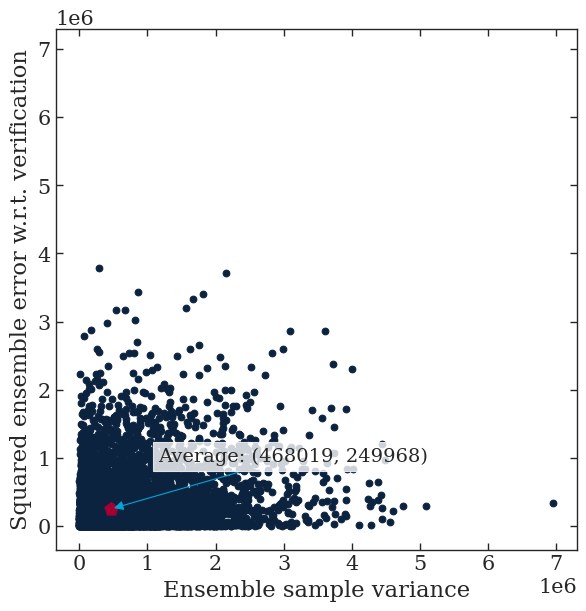

In [106]:
sample = cases[:-1]
verification = cases[-1:]

mean = np.mean(a=sample, axis=0)
var = np.var(a=sample, axis=0, ddof=1)
err = (mean - verification)**2

average_var = np.mean(var)
average_err = np.mean(err)

fig, ax = plt.subplots(figsize=(6, 6))

max_err = max(np.amax(var), np.amax(err))

ax.scatter(var, err)

ax.scatter(average_var, average_err, marker="p", s=100, label="Average")
ax.annotate(
    f"Average: ({average_var:.0f}, {average_err:.0f})",
    (average_var, average_err),
    (average_var + 0.1 * max_err, average_err + 0.1 * max_err),
    arrowprops=dict(arrowstyle="-|>", color="C2"),
    bbox=dict(facecolor="white", alpha=0.8),
    fontsize=14)

ax.set_aspect("equal")
ax.set_xlim([-0.05 * max_err, 1.05 * max_err])
ax.set_ylim([-0.05 * max_err, 1.05 * max_err])
ax.set_xlabel("Ensemble sample variance")
ax.set_ylabel("Squared ensemble error w.r.t. verification")

format_plot()
save_plot("../plots/lab2/", f"var_vs_err_pangu")